In [1]:
import h5py
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.layers import Conv2D, Dense, Input, LSTM
from keras.layers.embeddings import Embedding

from capsule_layers import CapsuleLayer, PrimaryCap, Length
from utils import load_image

Using TensorFlow backend.


## Load Dataset

In [2]:
# training data
h5f = h5py.File('dataset/train_data.h5', 'r')
x_train = h5f['x_train'][:]
y_train = h5f['y_train'][:]
h5f.close()

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)

x_train: (10000, 250, 250, 3)
y_train: (10000, 16)


In [3]:
# validation data
h5f = h5py.File('dataset/val_data.h5', 'r')
x_val = h5f['x_val'][:]
y_val = h5f['y_val'][:]
h5f.close()

print('x_val:', x_val.shape)
print('y_val:', y_val.shape)

x_val: (2500, 250, 250, 3)
y_val: (2500, 16)


## Load vocabulary and embeddings

In [4]:
def read_glove_vecs(glove_file):
    print('Creating word to vec map...')
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float32)
    print('Done!')
    return word_to_vec_map

In [5]:
# load embeddings
word_to_vec_map = read_glove_vecs('{}/glove.6B.100d.txt'.format('dataset'))

Creating word to vec map...
Done!


In [6]:
# assign embeddings values to tokens
size = word_to_vec_map['unk'].shape

word_to_vec_map['<sos>'] = np.random.uniform(low=-1.0, high=1.0, size=size)
word_to_vec_map['<eos>'] = np.random.uniform(low=-1.0, high=1.0, size=size)
word_to_vec_map['<pad>'] = np.random.uniform(low=-1.0, high=1.0, size=size)

In [7]:
# load vocabulary
with open('dataset/vocabulary.pickle', 'rb') as vocab_file:
    vocabulary_dict = pickle.load(vocab_file)

vocabulary = vocabulary_dict['vocabulary']
word_to_index = vocabulary_dict['word_to_index']
index_to_word = vocabulary_dict['index_to_word']

# number of words in vocabulary
num_words = len(vocabulary)

### Display a sample image-caption pair from the dataset

Caption: <sos> a person who is cooking in a kitchen <eos> <pad> <pad> <pad> <pad> <pad> <pad> 

Image:


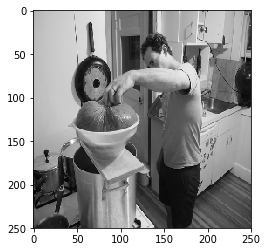

In [8]:
row_number = 1276
image_sample = x_train[row_number]
caption_idx = y_train[row_number]

caption_sample = ''
for idx in caption_idx:
    caption_sample += index_to_word[idx] + ' '

print('Caption:', caption_sample)
print('\nImage:')

plt.imshow(image_sample)
plt.show()

## Training Data

In [9]:
# input to encoder is the numpy array of the image
encoder_input_data = x_train
encoder_input_data_val = x_val

In [10]:
# input and output data for the decoder is identical, except shifted one time-step

# training
decoder_input_data = y_train[:, :-1]
decoder_output_data = y_train[:, 1:]

# validation
decoder_input_data_val = y_val[:, :-1]
decoder_output_data_val = y_val[:, 1:]

# Build Model

In [ ]:
tf.reset_default_graph()
K.clear_session()

In [12]:
# internal state size of LSTM layers in the RNN
state_size = 512
sequence_length = decoder_input_data.shape[1]

## Training Model

Create encoder (capsnet)

In [13]:
encoder_input_shape = x_train.shape[1:]  # (img_size, img_size, channels)
num_caption_caps = 80  # Number of capsules in caption caps layer (there are 80 categories in the dataset)
routings = 3

In [14]:
# placeholder for input image
encoder_input = Input(shape=encoder_input_shape, name='encoder_input')

In [15]:
# Layers 1-3: Three conventional Conv2D layers
conv1 = Conv2D(filters=96, kernel_size=13, strides=4, padding='valid', activation='relu', name='conv1')(encoder_input)
conv2 = Conv2D(filters=96, kernel_size=5, strides=2, padding='valid', activation='relu', name='conv2')(conv1)
conv3 = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv3')(conv2)
    
# Layer 4: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
primary_caps = PrimaryCap(conv3, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

# Layer 5: Capsule layer. Routing algorithm works here.
caption_caps = CapsuleLayer(num_capsule=num_caption_caps, dim_capsule=16, routings=routings, name='caption_caps')(primary_caps)

# Convert the ouput to the required dimensions
capsnet_output = Length(name='capsnet')(caption_caps)

In [16]:
# The ouput of the encoder is given to the LSTM as an initial state,
# so the dimensions of the encoder_output and decoder_initial_hidden_state must match.
# Thus, a fully-connected layer is used to map the vectors from num_caption_caps to state_size elements.
encoder_output = Dense(state_size, activation='relu', name='decoder_transfer_map')(capsnet_output)

Create decoder (RNN)

In [17]:
def create_embedding_layer(word_to_index, word_to_vec_map, num_words):
    """ Create a Keras Embedding() layer and load in pre-trained GloVe 100-dimensional vectors
        @params:
        :word_to_index -- dictionary containing the each word mapped to its index
        :word_to_vec_map -- dictionary mapping words to their GloVe vector representation
        :num_words -- number of words in the vocabulary
        
        @return:
        :decoder_embedding -- pretrained layer Keras instance
    """
    
    vocabulary_length = num_words + 1  # adding 1 to fit Keras embedding (requirement)
    embedding_dimensions = word_to_vec_map['unk'].shape[0]  # define dimensionality of GloVe word vectors (= 100)
    
    embedding_matrix = np.zeros((vocabulary_length, embedding_dimensions))  # initialize with zeros
    for word, index in word_to_index.items():
        try:
            embedding_matrix[index, :] = word_to_vec_map[word]
        except KeyError:
            embedding_matrix[index, :] = word_to_vec_map['unk']
    
    # we don't want the embeddings to be updated, thus trainable parameter is set to False
    decoder_embedding = Embedding(vocabulary_length, embedding_dimensions, trainable=False)
    decoder_embedding.build((None,))
    decoder_embedding.set_weights([embedding_matrix])  # with this the layer is now pretrained
    
    return decoder_embedding

In [18]:
# input for the token sequences to the decoder
decoder_input = Input(shape=(sequence_length,), name='decoder_input')

# pretrained embedding layer
decoder_embedding = create_embedding_layer(word_to_index, word_to_vec_map, num_words)

# LSTM 1 states
cell_state_1 = Input(shape=(state_size,), name='cell_state_1')  # cell state
hidden_state_1 = Input(shape=(state_size,), name='hidden_state_1')  # hidden state

# LSTM 2 states
cell_state_2 = Input(shape=(state_size,), name='cell_state_2')  # cell state
hidden_state_2 = Input(shape=(state_size,), name='hidden_state_2')  # hidden state

# LSTM layers of the decoder
lstm_1 = LSTM(state_size, return_sequences=True, return_state=True, name='lstm_1')
lstm_2 = LSTM(state_size, return_sequences=True, return_state=True, name='lstm_2')

# output of the decoder model
decoder_dense = Dense(num_words, activation='softmax', name='decoder_outputs')

In [19]:
# Start the decoder network

# Layer 1: embedding layer
decoder_network = decoder_embedding(decoder_input)

# Layers 2 and 3
decoder_network, _, _ = lstm_1(decoder_network, initial_state=[encoder_output, cell_state_1])
decoder_network, _, _ = lstm_2(decoder_network, initial_state=[encoder_output, cell_state_2])

# Connect the final dense layer that converts to one-hot encoded arrays
decoder_outputs = decoder_dense(decoder_network)

In [20]:
# Model 1
model_train = Model(
    inputs=[encoder_input, decoder_input, cell_state_1, cell_state_2],
    outputs=decoder_outputs
)

In [21]:
model_train.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 60, 60, 96)   48768       encoder_input[0][0]              
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 28, 28, 96)   230496      conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 20, 20, 256)  1990912     conv2[0][0]                      
__________________________________________________________________________________________________
primarycap

In [22]:
optimizer = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model_train.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

## Encoder Model

In [23]:
# Model 2
model_encoder = Model(inputs=encoder_input, outputs=encoder_output)

## Decoder Model

In [25]:
decoder_network = decoder_embedding(decoder_input)
decoder_network, state_h_1, state_c_1 = lstm_1(decoder_network, initial_state=[hidden_state_1, cell_state_1])
decoder_network, state_h_2, state_c_2 = lstm_2(decoder_network, initial_state=[hidden_state_2, cell_state_2])
decoder_output = decoder_dense(decoder_network)

decoder_states = [state_h_1, state_c_1, state_h_2, state_c_2]

In [26]:
# Model 3
model_decoder = Model(
    inputs=[decoder_input] + [hidden_state_1, cell_state_1] + [hidden_state_2, cell_state_2],
    outputs=[decoder_output] + decoder_states
)

## Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

In [27]:
# callback for writing checkpoints during training
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(
    filepath=path_checkpoint,
    monitor='val_loss',
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

In [28]:
# callback for stopping the optimization when performance worsens on the validation-set
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [29]:
# callback for writing the TensorBoard log during training
callback_tensorboard = TensorBoard(log_dir='./logs/', histogram_freq=0, write_graph=False)

In [30]:
callbacks = [callback_early_stopping, callback_checkpoint, callback_tensorboard]

## Train model

### Load checkpoint

In [ ]:
try:
    model_train.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

### Begin Training

In [34]:
x_data_train = {
    'encoder_input': encoder_input_data,
    'decoder_input': decoder_input_data,
    'cell_state_1': np.zeros((x_train.shape[0], state_size)),
    'cell_state_2': np.zeros((x_train.shape[0], state_size))
}

y_data_train = {
    'decoder_outputs': np.expand_dims(decoder_output_data, axis=-1)  # Keras bug with sparse categorical crossentropy loss
}

In [35]:
x_data_val = {
    'encoder_input': encoder_input_data_val,
    'decoder_input': decoder_input_data_val,
    'cell_state_1': np.zeros((x_val.shape[0], state_size)),
    'cell_state_2': np.zeros((x_val.shape[0], state_size))
}

y_data_val = {
    'decoder_outputs': np.expand_dims(decoder_output_data_val, axis=-1)  # Keras bug with sparse categorical crossentropy loss
}

In [36]:
model_train.fit(
    x=x_data_train,
    y=y_data_train,
    batch_size=64,
    epochs=10,
    callbacks=callbacks,
    validation_data=(x_data_val, y_data_val)
)

Train on 10000 samples, validate on 2500 samples
Epoch 1/10
10000/10000 [==============================] - 1103s 110ms/step - loss: 4.5045 - val_loss: 4.1890

Epoch 00001: val_loss improved from inf to 4.18902, saving model to checkpoint.keras
Epoch 2/10
10000/10000 [==============================] - 1089s 109ms/step - loss: 4.0359 - val_loss: 4.0044

Epoch 00002: val_loss improved from 4.18902 to 4.00444, saving model to checkpoint.keras
Epoch 3/10
10000/10000 [==============================] - 1097s 110ms/step - loss: 3.8989 - val_loss: 3.9169

Epoch 00003: val_loss improved from 4.00444 to 3.91693, saving model to checkpoint.keras
Epoch 4/10
10000/10000 [==============================] - 1084s 108ms/step - loss: 3.8340 - val_loss: 3.8792

Epoch 00004: val_loss improved from 3.91693 to 3.87917, saving model to checkpoint.keras
Epoch 5/10
10000/10000 [==============================] - 1089s 109ms/step - loss: 3.7922 - val_loss: 3.8441

Epoch 00005: val_loss improved from 3.87917 to 3.

## Generate Captions

In [38]:
def generate_caption(image_path):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    img = load_image(image_path, size=x_train.shape[1:3], color=True)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(img, axis=0)

    # Process the image with the pre-trained image-model
    state_h_1 = model_encoder.predict(image_batch)
    state_h_2 = np.copy(state_h_1)
    
    # Cell states
    state_c_1 = np.zeros((1, state_size))
    state_c_2 = np.zeros((1, state_size))

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, sequence_length)
    input_data = np.zeros(shape=shape, dtype=np.int64)

    # The first input-token is the special start-token for 'ssss '.
    token_int = word_to_index['<sos>']
    token_end = word_to_index['<eos>']

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for '<eos>'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < sequence_length:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = {
            'decoder_input': input_data,
            'hidden_state_1': state_h_1,
            'cell_state_1': state_c_1,
            'hidden_state_2': state_h_2,
            'cell_state_2': state_c_2
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the LSTM-states when calling predict() and then
        # feeding these LSTM-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output, state_h_1, state_c_1, state_h_2, state_c_2 = model_decoder.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = index_to_word[token_int]

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(img)  # display in RGB format
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

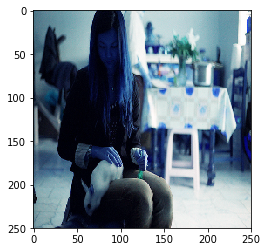

Predicted caption:
 a <eos>



In [40]:
generate_caption("dataset/test2017/000000436642.jpg")